In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# SEP532 인공지능 이론과 실제
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

### Time series forecasting 
In this practice, We will cover the two parts: first, we will forecast a univariate time series, then we will forecast a multivariate time series.

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#### The weather dataset
This practice uses a [`weather time series dataset`](https://www.bgc-jena.mpg.de/wetter/) recorded by the Max-Planck-Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. 

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

The data is in the form of CSV. If you cannot handle the CSV data well in Tensorflow, check this tutorial: https://www.tensorflow.org/beta/tutorials/load_data/from_pandas.

In [4]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations.

Given a specific time, let's say **you want to predict the temperature 6 hours in the future**. **In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model**. Many such configurations are possible, making this dataset a good one to experiment with.

**The function below returns the above described windows of time for the model to train on**. The parameter `history_size` is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In both the following practices, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [7]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [8]:
tf.random.set_seed(13)

### Part 1: Forecast a univariate time series
First, you will train a model **using only a single feature (temperature)**, and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<AxesSubplot:xlabel='Date Time'>], dtype=object)

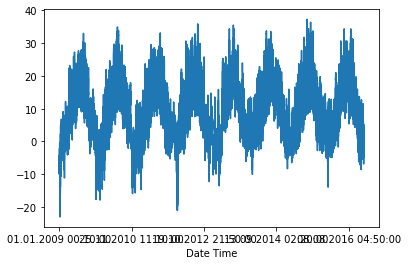

In [10]:
uni_data.plot(subplots=True)

In [11]:
uni_data = uni_data.values

It is important to **normalize features before training a neural network**. A **common way to do so is by subtracting the mean and dividing by the standard deviation** of each feature.

_Note: The mean and standard deviation should only be computed using the training data._

In [12]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [13]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now **create the data for the univariate model**. For part 1, **the model will be given the last 20 recorded temperature observation**s, and needs to learn to **predict the temperature at the next time step**.

In [16]:
univariate_past_history = 20
univariate_future_target = 1

# Create training dataset with univariate feature
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [17]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.0949220845536356


Now that the data has been created, let's take a look at a single example. The information given to the network is given in _blue_, and it must predict the value at the _red cross_.

In [18]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [19]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

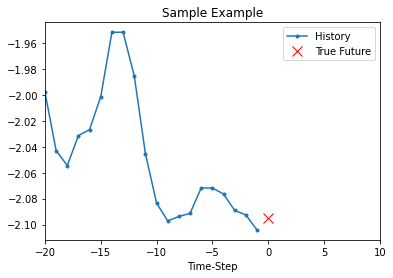

In [20]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

#### Baseline
Before proceeding to train a model, let's first **set a simple baseline**. Given an input point, the baseline method looks at all the history and **predicts the next point to be the average of the last 20 observations**.

In [21]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

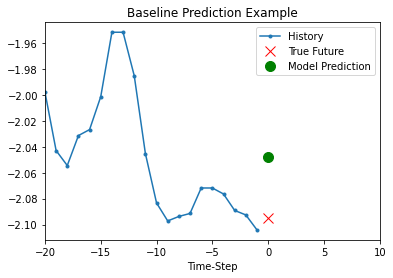

In [22]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

#### Recurrent neural network
**RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far.** In this practical, we will use a specialized RNN layer called Long Short Tem Memory (LSTM)

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [23]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

2022-05-09 12:57:27.961912: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 12:57:28.625371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:af:00.0, compute capability: 8.0


In [24]:
simple_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model.

In [25]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape) # (BATCH_SIZE, Predicted_value)

2022-05-09 12:57:33.118156: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [26]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
  1/200 [..............................] - ETA: 5:06 - loss: 1.0852

2022-05-09 12:57:35.440190: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


200/200 [==============================] - 4s 12ms/step - loss: 0.4120 - val_loss: 0.1440
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1217 - val_loss: 0.0439
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0604 - val_loss: 0.0373
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0550 - val_loss: 0.0338
Epoch 5/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0395 - val_loss: 0.0321
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0429 - val_loss: 0.0311
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0394 - val_loss: 0.0296
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0373 - val_loss: 0.0287
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0373 - val_loss: 0.0277
Epoch 10/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0339 - val_loss: 0.0266


In [52]:
!mkdir -p time-series-forecasting/simple-lstm
simple_lstm_model.save('time-series-forecasting/simple-lstm.h5')

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

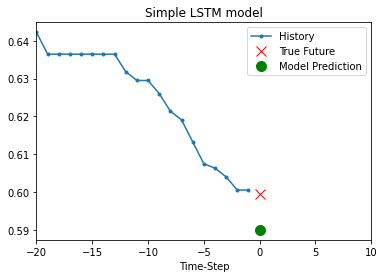

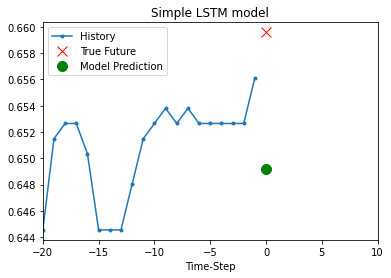

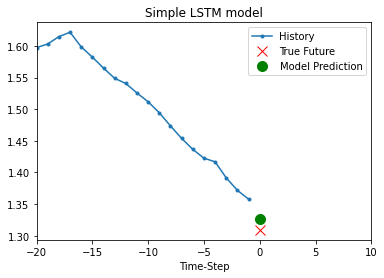

In [28]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

### Part 2: Forecast a multivariate time series
The original dataset contains **fourteen features**. For simplicity, this part **considers only three of the original fourteen**. The features used are air temperature, atmospheric pressure, and air density.

To use more features, add their names to this list.

In [26]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [27]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

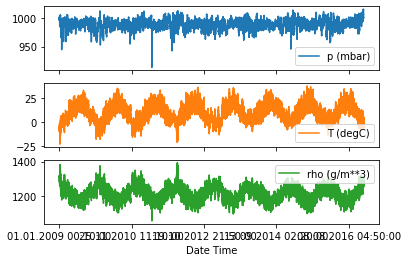

In [28]:
features.plot(subplots=True)

As mentioned, the **first step will be to normalize the dataset** using the mean and standard deviation of the training data.

In [29]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

In [30]:
dataset = (dataset-data_mean)/data_std

#### Single step model
In a single step setup, **the model learns to predict a single point** in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
    
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In this practice, **the network is shown data from the last five (5) days**, i.e. 720 observations that are sampled every hour. **The sampling is done every one hour since a drastic change is not expected within 60 minutes.** Thus, 120 observation represent history of the last five days. For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [32]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.

In [33]:
# 120 observations, 3 features 
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [34]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [35]:
single_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
    
])

single_step_model.compile(optimizer='rmsprop', loss='mae')

Let's check out a sample prediction.

In [36]:
for x, y in val_data_single.take(1):  
    print(single_step_model.predict(x).shape)

(256, 1)


In [37]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 6s 21ms/step - loss: 0.3193 - val_loss: 0.2693
Epoch 2/10
200/200 [==============================] - 4s 20ms/step - loss: 0.2687 - val_loss: 0.2496
Epoch 3/10
200/200 [==============================] - 4s 19ms/step - loss: 0.2675 - val_loss: 0.2523
Epoch 4/10
200/200 [==============================] - 4s 19ms/step - loss: 0.2631 - val_loss: 0.2525
Epoch 5/10
200/200 [==============================] - 4s 19ms/step - loss: 0.2316 - val_loss: 0.2439
Epoch 6/10
200/200 [==============================] - 4s 19ms/step - loss: 0.2472 - val_loss: 0.2737
Epoch 7/10
200/200 [==============================] - 4s 19ms/step - loss: 0.2464 - val_loss: 0.2629
Epoch 8/10
200/200 [==============================] - 4s 19ms/step - loss: 0.2454 - val_loss: 0.2439
Epoch 9/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2490 - val_loss: 0.2522
Epoch 10/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2443 - val_lo

In [38]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

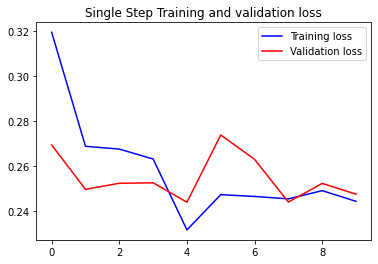

In [39]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The **model is given the history of three features over the past five days sampled every hour (120 data-points)**, since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction).

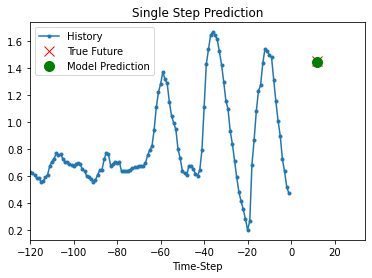

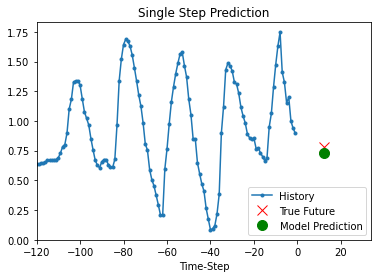

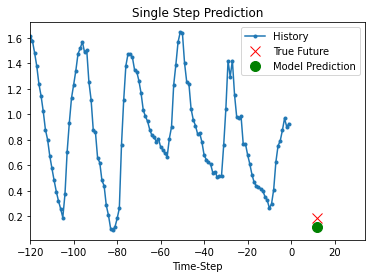

In [40]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    
    plot.show()

In a multi-step prediction model, given a past history, the **model needs to learn to predict a range of future values**. Thus, unlike a single step model, where only a single future point is predicted, **a multi-step model predict a sequence of the future**.

For the multi-step model, **the training data again consists of recordings over the past five days sampled every hour**. However, here, the model needs to learn to predict the temperature for the next 12 hours. **Since an obversation is taken every 10 minutes, the output is 72 predictions.** For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [41]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [42]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [43]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [44]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

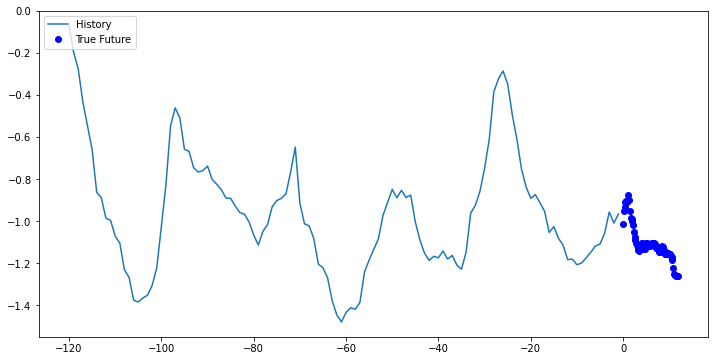

2022-05-08 23:50:36.697983: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [45]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, **the model now consists of two LSTM layers**. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [46]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(16))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [47]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [48]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 9s 30ms/step - loss: 0.4612 - val_loss: 0.2996
Epoch 2/10
200/200 [==============================] - 6s 28ms/step - loss: 0.2883 - val_loss: 0.2430
Epoch 3/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2574 - val_loss: 0.2282
Epoch 4/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2331 - val_loss: 0.2042
Epoch 5/10
200/200 [==============================] - 5s 27ms/step - loss: 0.1987 - val_loss: 0.2003
Epoch 6/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2071 - val_loss: 0.2237
Epoch 7/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2019 - val_loss: 0.2128
Epoch 8/10
200/200 [==============================] - 5s 27ms/step - loss: 0.1993 - val_loss: 0.2246
Epoch 9/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2024 - val_loss: 0.1994
Epoch 10/10
200/200 [==============================] - 5s 27ms/step - loss: 0.1918 - val_lo

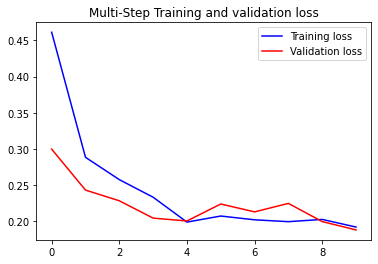

In [49]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

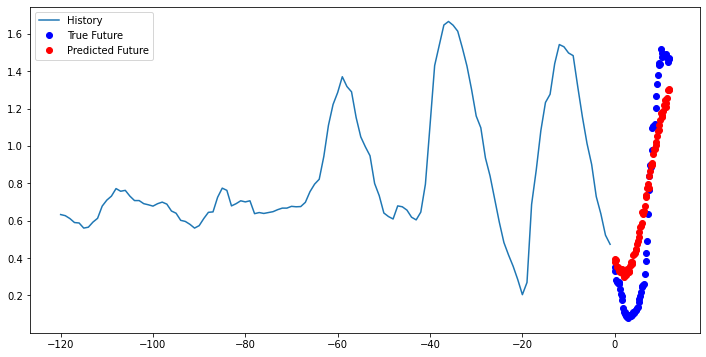

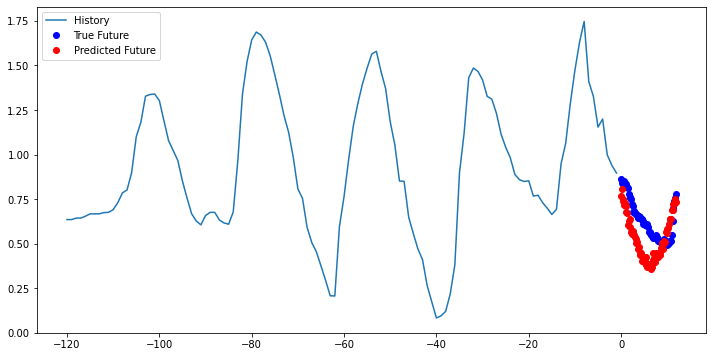

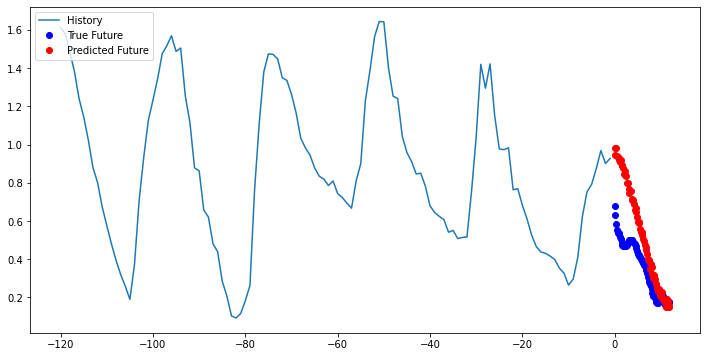

In [50]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])